In [1]:
!pip install lightgbm

In [1]:
# path

neologd_dict_path = '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd'
font_path = "/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf"
blog_save_dir = '/keyakizaka_mining/data/blog'

In [2]:
# library

import gc
import pandas as pd
import numpy as np
import seaborn as sns

# NLR
import re
import MeCab
mecab = MeCab.Tagger (r"-Ochasen")
# mecab = MeCab.Tagger (r"-Ochasen -d %s" % neologd_dict_path)
mecab.parse("")

from gensim.models import FastText

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture

# ML
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
# japanese plot setting

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()

In [4]:
# functions

def get_tokens( text, ):
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        tokens.append( result.surface )
        result = result.next
    return tokens

def get_tokens_pos( text, target_pos ):
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        if pos in target_pos: tokens.append( result.surface )
        result = result.next
    return tokens

def get_tokens_with_pos( text ):
    pos_tokens = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        pos_tokens.append( (result.surface, pos) )
        result = result.next
    return pos_tokens

In [5]:
# functions for lstyle

# 非内容語の使用率　(非内容語のunigramらしい?)

def get_noncontent_rate( texts_pos, n, cut_off_num ):

    content_pos = ['名詞','動詞','形容詞'] # 内容語
    
    novels_pos_str = []
    for token_pos in texts_pos:
        text = ' '.join( [ t[0] for t in token_pos if not t[1] in content_pos ] )
        novels_pos_str.append( text )

    vectorizer = CountVectorizer(
        min_df = cut_off_num,
        ngram_range = (n, n),
    )
    X = vectorizer.fit_transform( novels_pos_str )
    
    return X.toarray()

# 品詞のn-gram

def get_pos_ngram( texts_pos, n, cut_off_num ):

    novels_pos_str = []
    for token_pos in texts_pos:
        text = ' '.join( [t[1] for t in token_pos] )
        novels_pos_str.append( text )

    vectorizer = CountVectorizer(
        min_df = cut_off_num,
        ngram_range = (n, n),
    )
    X = vectorizer.fit_transform( novels_pos_str )
    return X.toarray()

# 助詞のn-gram

def get_adp_ngram( texts_pos, n, cut_off_num ):

    novels_pos_str = []
    for token_pos in texts_pos:
        text = ' '.join( [ t[0] for t in token_pos if t[1] == "助詞" ] )
        novels_pos_str.append( text )

    vectorizer = CountVectorizer(
        min_df = cut_off_num,
        ngram_range = (n, n),
    )
    X = vectorizer.fit_transform( novels_pos_str )
    return X.toarray()

# 文字のn-gram

def get_char_ngram( texts_pos, n, cut_off_num ):

    n = 3
    cut_off_num = 50

    novels_pos_str = []
    for token_pos in texts_pos:
        text = ''
        for t in token_pos:
            for c in t[0]: text += c
        novels_pos_str.append( text )

    vectorizer = CountVectorizer(
        min_df = cut_off_num,
        ngram_range = (n, n),
        analyzer='char'
    )
    X = vectorizer.fit_transform( novels_pos_str )
    return X.toarray()

# ひらがな、カタカナ、漢字、数字, 英数字, の使用率

def get_char_kind_rate( texts_pos ):

    re_hiragana = re.compile(r'[\u3041-\u3093]')
    re_katakana = re.compile(r'[\u30A1-\u30F4]+')
    re_kanji = re.compile('[\u4E00-\u9FD0]')
    re_number = re.compile(r'\d') # 全角も含む
    re_alpha = re.compile(r'^[a-zA-Z]+$')
    
    char_kind_rates = []
    for tokens_pos in texts_pos:
        char_num = 1
        char_kind_count = [1,1,1,1,1]
        for i in tokens_pos:
            if len( i[0] ) < 1: continue
            for c in i[0]:
                if re_hiragana.fullmatch(c): char_kind_count[0] += 1
                if re_katakana.fullmatch(c):char_kind_count[1] += 1
                if re_kanji.fullmatch(c): char_kind_count[2] += 1
                if re_number.fullmatch(c): char_kind_count[3] += 1
                if re_alpha.fullmatch(c): char_kind_count[4] += 1
                char_num += 1
        char_kind_rates.append( [ i / float( char_num ) for i in char_kind_count] )
    X = np.array( char_kind_rates )
    return X

# 読点前の単語

def get_comma_before_word( texts_pos, cut_off_num  ):

    novels_pos_str = []
    for token_pos in texts_pos:
        text = ''
        for t in token_pos:
            if t[0] == '、': text += '%s ' % t_prev[0]
            t_prev = t
        novels_pos_str.append( text )

    vectorizer = CountVectorizer(
        min_df = cut_off_num,
    )
    X = vectorizer.fit_transform( novels_pos_str )
    return X.toarray()

In [6]:
# read blog data

df = pd.read_csv( '%s/keyakizaka46_blog_20190217.csv' % (blog_save_dir) )
print( df.shape )
df.head()

(16754, 6)


,author,datetime,title,text,images,url
0,齋藤冬優花,2015/11/1400:02,＼はじめまして︎︎❤︎︎1/︎︎,\n お見立て会前日にして始まりましたっ!欅坂46ブログ(*ﾟ▽ﾟ)ﾉ嬉しくて嬉しくて、、、...,http://cdn.keyakizaka46.com/files/14/diary/k46...,http://www.keyakizaka46.com/s/k46o/diary/detai...
1,菅井友香,2015/11/1323:54,菅井友香です(^ ^),\n初めまして(^ ^)!この度欅坂46として活動させて頂けることになりました、東京都出身1...,http://cdn.keyakizaka46.com/files/14/diary/k46...,http://www.keyakizaka46.com/s/k46o/diary/detai...
2,尾関梨香,2015/11/1323:52,じゃじゃじゃーーん①,\nはじめまして(^ν^)神奈川県出身高校3年生18歳の尾関梨香です。いよいよ本日からブログ...,http://cdn.keyakizaka46.com/files/14/diary/k46...,http://www.keyakizaka46.com/s/k46o/diary/detai...
3,小林由依,2015/11/1323:51,はじまりました☆彡,\n「皆」という漢字の下の部分が 日 ではなく、白ということを最近知りました。小林由依です♪...,NaN,http://www.keyakizaka46.com/s/k46o/diary/detai...
4,小池美波,2015/11/1323:49,みなさん初めまして、小池美波です♪,\nみなさん初めまして!高校二年生、兵庫県出身の小池美波です!ついに明日は欅坂46の初イベン...,http://cdn.keyakizaka46.com/files/14/diary/k46...,http://www.keyakizaka46.com/s/k46o/diary/detai...


In [7]:
# 記事数が少ない著者を除去

target = df['author'].value_counts().index[:-2]
df = df[df['author'].isin(target)]

In [8]:
seed = 46
for i, t in enumerate( target ):
    if i == 0:
        df_sampled = df.query('author == "%s"' % t).sample(n=98, random_state=seed)
    else:
        tmp = df.query('author == "%s"' % t).sample(n=98, random_state=seed)
        df_sampled = pd.concat([df_sampled, tmp])

In [9]:
# read pos

sentences = [ get_tokens_with_pos( text ) for text in df_sampled['text'].values ]

In [10]:
# get features

X_noncontent_rate = get_noncontent_rate( sentences, n=1, cut_off_num=5 ); print('noncontent_rate',X_noncontent_rate.shape)
X_pos_ngram = get_pos_ngram( sentences, n=3, cut_off_num=5 ); print('pos_ngram',X_pos_ngram.shape)
X_adp_ngram = get_adp_ngram( sentences, n=2, cut_off_num=5 ); print('adp_ngram',X_adp_ngram.shape)
# X_char_ngram = get_char_ngram( sentences, n=2, cut_off_num=50 )
X_comma_before_word = get_comma_before_word( sentences, cut_off_num=2 ); print('comma_before_word', X_comma_before_word.shape)
X_char_kind_rate = get_char_kind_rate( sentences )

noncontent_rate (3724, 612)
pos_ngram (3724, 988)
adp_ngram (3724, 878)
comma_before_word (3724, 758)


In [11]:
# concat features

X = np.concatenate([X_noncontent_rate, X_pos_ngram, X_adp_ngram, X_comma_before_word, X_char_kind_rate], 1)
X = np.array(X)
print( X.shape )

(3724, 3241)


In [12]:
# labels

y = df_sampled['author'].values

In [13]:
def plot_confusion_matrix( clf, true, preds ):
    cm = confusion_matrix(true, preds)
    # cm = cm.astype('float') / cm.astype(np.float).sum(axis=0)
    
    df_cm = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)

    plt.figure(figsize = (20,14))
    sns.heatmap(df_cm, annot=True, cmap='Oranges') # , fmt='.1f'
    plt.show()
    return

def cv_randomforest( X, y ):
    # learn (5-fold cv)
    acc_score_cv = []
    cm_sum = np.zeros( ( len(target), len(target) ) )

    kf = StratifiedKFold(n_splits=5, random_state=777, shuffle=True)
    for idx, (train, val) in enumerate( kf.split(X, y) ):
        print( "fold -", idx )

        # learn model
        clf = RandomForestClassifier(n_estimators=100, n_jobs=7)
        # clf = lgb.LGBMClassifier(n_estimators=100, objective="multiclass")
        clf.fit(X[train], y[train])

        # predict validation and score
        preds = clf.predict(X[val])
        acc_cv = accuracy_score( preds, y[val] )
        acc_score_cv.append( acc_cv )
        
        # classification report
        # print( classification_report(y[val], preds) )

        # plot confusion matrix
        #plot_confusion_matrix( clf, y[val], preds )

        cm = confusion_matrix(y[val], preds)
        cm_sum += cm
        
    # cv score
    mean = sum( acc_score_cv ) / len( acc_score_cv )
    print( acc_score_cv )
    print( 'Mean:', mean )
    
    df_cm = pd.DataFrame(cm_sum, index=clf.classes_, columns=clf.classes_)
    plt.figure(figsize = (20,14))
    sns.heatmap(df_cm, annot=True, cmap='Oranges') # , fmt='.1f'
    plt.show()  
    return mean

def cv_lightgbm( X, y ):
    # learn (5-fold cv)
    acc_score_cv = []
    cm_sum = np.zeros( ( len(target), len(target) ) )

    kf = StratifiedKFold(n_splits=5, random_state=777, shuffle=True)
    for idx, (train, val) in enumerate( kf.split(X, y) ):
        print( "fold -", idx )

        # learn model
        clf = lgb.LGBMClassifier(n_estimators=100, objective="multiclass")
        clf.fit(X[train], y[train])

        # predict validation and score
        preds = clf.predict(X[val])
        acc_cv = accuracy_score( preds, y[val] )
        acc_score_cv.append( acc_cv )
        
        # classification report
        # print( classification_report(y[val], preds) )

        # plot confusion matrix
        # plot_confusion_matrix( clf, y[val], preds )
        cm = confusion_matrix(y[val], preds)
        cm_sum += cm

    # cv score
    mean = sum( acc_score_cv ) / len( acc_score_cv )
    print( acc_score_cv )
    print( 'Mean:', mean )
    
    df_cm = pd.DataFrame(cm_sum, index=clf.classes_, columns=clf.classes_)
    plt.figure(figsize = (20,14), dpi=200)
    sns.heatmap(df_cm, annot=True, cmap='Oranges') # , fmt='.1f'
    plt.show()  
    return mean

In [14]:
X_names =[
    "非内容語の使用率",
    "品詞のn-gram",
    "助詞のn-gram",
    "読点前の単語",
    "漢字・ひらがな・カタカナ・数字・ローマ字の使用率",
    "ALL - [非内容語の使用率]",
    "ALL - [品詞のn-gram]",
    "ALL - [助詞のn-gram]",
    "ALL - [読点前の単語]",
    "ALL - [漢字・ひらがな・カタカナ・数字・ローマ字の使用率]",
    "ALL"
]
X_list = [
    X_noncontent_rate,
    X_pos_ngram,
    X_adp_ngram,
    X_comma_before_word,
    X_char_kind_rate,
    np.concatenate([X_pos_ngram, X_adp_ngram, X_comma_before_word, X_char_kind_rate], 1),
    np.concatenate([X_noncontent_rate, X_adp_ngram, X_comma_before_word, X_char_kind_rate], 1),
    np.concatenate([X_noncontent_rate, X_pos_ngram, X_comma_before_word, X_char_kind_rate], 1),
    np.concatenate([X_noncontent_rate, X_pos_ngram, X_adp_ngram, X_char_kind_rate], 1),
    np.concatenate([X_noncontent_rate, X_pos_ngram, X_adp_ngram, X_comma_before_word], 1),
    X
]

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"


rows = []

for idx, X_tmp in enumerate(X_list):
    
    print( idx, X_names[idx], "Random Forest" )
    cv_score_rf = cv_randomforest(X_tmp, y)
    
    print( idx, X_names[idx], "LightGBM" )
    cv_score_lgbm = cv_lightgbm(X_tmp, y)
    
    rows.append( [cv_score_rf, cv_score_lgbm] )

In [17]:
import pytablewriter
pd.options.display.float_format = '{:.4f}'.format

new_names = X_names[0:5] + [X_names[-1]]
new_rows = rows[0:5] + [rows[-1]]
result = pd.DataFrame( new_rows, index=new_names, columns=['Random Forest', 'LightGBM'] )
display(result)

writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(result, add_index_column=True)
writer.write_table()

,Random Forest,LightGBM
非内容語の使用率,0.5239,0.5499
品詞のn-gram,0.7300,0.7849
助詞のn-gram,0.1315,0.1227
読点前の単語,0.1549,0.1554
漢字・ひらがな・カタカナ・数字・ローマ字の使用率,0.1165,0.1094
ALL,0.7700,0.8351


|                                                |Random Forest|LightGBM|
|------------------------------------------------|------------:|-------:|
|非内容語の使用率                                |       0.5239|  0.5499|
|品詞のn-gram                                    |       0.7300|  0.7849|
|助詞のn-gram                                    |       0.1315|  0.1227|
|読点前の単語                                    |       0.1549|  0.1554|
|漢字・ひらがな・カタカナ・数字・ローマ字の使用率|       0.1165|  0.1094|
|ALL                                             |       0.7700|  0.8351|


In [18]:
new_names = X_names[5:]
new_rows = rows[5:]
result = pd.DataFrame( new_rows, index=new_names, columns=['Random Forest', 'LightGBM'] )
display(result)

writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(result, add_index_column=True)
writer.write_table()

,Random Forest,LightGBM
ALL - [非内容語の使用率],0.7340,0.8019
ALL - [品詞のn-gram],0.5662,0.6157
ALL - [助詞のn-gram],0.7720,0.8370
ALL - [読点前の単語],0.7715,0.8346
ALL - [漢字・ひらがな・カタカナ・数字・ローマ字の使用率],0.7627,0.8307
ALL,0.7700,0.8351


|                                                        |Random Forest|LightGBM|
|--------------------------------------------------------|------------:|-------:|
|ALL - [非内容語の使用率]                                |       0.7340|  0.8019|
|ALL - [品詞のn-gram]                                    |       0.5662|  0.6157|
|ALL - [助詞のn-gram]                                    |       0.7720|  0.8370|
|ALL - [読点前の単語]                                    |       0.7715|  0.8346|
|ALL - [漢字・ひらがな・カタカナ・数字・ローマ字の使用率]|       0.7627|  0.8307|
|ALL                                                     |       0.7700|  0.8351|


In [ ]:
!pip install pytablewriter

In [128]:
import pytablewriter

writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(result, add_index_column=True)
writer.write_table()

|                                                      |  RF  | LGBM |
|------------------------------------------------------|-----:|-----:|
|非内容語の使用率                                      |0.4492|0.3869|
|品詞のn-gram                                          |0.7337|0.7849|
|助詞のn-gram                                          |0.1333|0.1227|
|読点前の単語                                          |0.1533|0.1554|
|漢字・ひらがな・カタカナ・数字・ローマ字の使用率      |0.1139|0.1094|
|all - 非内容語の使用率                                |0.7309|0.8019|
|all - 品詞のn-gram                                    |0.5452|0.4933|
|all - 助詞のn-gram                                    |0.7598|0.8168|
|all - 読点前の単語                                    |0.7576|0.8158|
|all - 漢字・ひらがな・カタカナ・数字・ローマ字の使用率|0.7585|0.8084|
|all                                                   |0.7621|0.8168|


In [150]:
for t in df_sampled.query('author == "守屋茜"')[['datetime','text']].values[:10]:
    print( t[0], t[1].replace('\n','') )
    print( '-------------------------------' )

2016/01/2318:09 ぐらふたぬーん(´｡✪ω✪｡ ` )ぬーん。ぬんぬんファンレター第3弾!!いただいた日に家に帰ってすぐに読みました。1回読み出したら嬉しくて嬉しくて次も!次も…!!と読んでしまいました( ˊᵕˋ )♡読みながら、私にファンレターを書くためにレターセットを選びに行ってくれたり、私の好きそうなデザインのもので書いてくれたり… 本当にありがとうございます。ファンレターってすごいです。元気いっぱいパワーアップ出来そうです(੭ˊ꒳​ˋ)੭✧いつでも読み返せるように専用のボックスに綺麗に収納しています(　^ω^)いつか私もファンの方々に恩返しできるように頑張ります。オフショッーーーーーと!ヤングマガジン、samurai ELOみなさんみていただけましたか～今日本屋さんでみてきました。あとCancam3月号が今日発売だったので購入しました。愛読しています( ˶˙ᴗ˙˶ )\♥︎/samurai ELOの方は二号連続で出させていただいています(ˊo̶̶̷ᴗo̶̶̷`)次回もおたのしみに♡バレンタインカード、気合いをいれてがんばって可愛くデザインしたのでどうかご応募よろしくお願いします(*ˊ˘ˋ*)｡♪:*°ヤングマガジン٩( ü )و❅:*.。 ｡.*:❅セーラー服着れてハッピー!ハッピー!ハッピー!でした⍤⃝♡ 7人のいつもとは違った表情がご覧いただけけると思いますのでぜひGETしてください❤︎次のブログで個人のオフショット載せます(灬ꈍ ꈍ灬)そして!スカパー音楽祭2016に出演させていただきますT^T☆*。☆*。!!みなさんの心に響くパフォーマンスができるように頑張ります。2/28日曜日の生放送です。ご視聴お願いします!またね〜ん。あかねん(⑉• •⑉)(⑉• •⑉)❤︎  
-------------------------------
2016/05/2518:18 いぇええええええい!!着々と入場時間が迫ってますね♡盛り上がる準備は満タンですか?コラボTシャツ!!♡これすっごく欲しくてなんと!なんと頂きました〜〜うれしい٩(๑˃̵ᴗ˂̵๑)۶ °٩(๑˃̵ᴗ˂̵๑)۶ °ファンのみなさんもGETして、おそろっぴしましょぉおお♪さっそく頂いてからすぐに着ちゃった¨̮♡それでは!!イベントでお会いしましょっ\♥︎/またねん!あかねん。  
-

In [151]:
for t in df_sampled.query('author == "丹生明里"')[['datetime','text']].values[:10]:
    print( t[0], t[1].replace('\n','') )
    print( '-------------------------------' )

2018/05/2600:52 みなさんこんにちは〜٩( ᐛ )و٩( ᐛ )و٩( ᐛ )وけやき坂46 2期生 丹生明里です🐸🥕ベンチコート〜squint🙂最近、こんにゃくにハマろうとしました!お友達からもこんにゃくをオススメされたので、夜に食べようᐠ( ᐝ̱ )ᐟと頑張ったのですが…元からあまりこんにゃくを好んで食べなかったので、味にも慣れなくて、こんにゃくを好きになりたい!沢山食べたい!と思ってもどうしても味があまり受けつけられなくて、~こんにゃくを食べようଘ( ᐛ ) ଓ生活~があっけなく終了しました… 笑これは私の味付けの問題なのでしょうか…?🤔いや違うよ!こんにゃくの味だ!あっ、でも味を少し濃くすれば、なんとなーくカモフラージュされて食べれますかね!やっぱりもう一回がんばろうかな〜あ、私よく一人で解決しちゃう人です(ちっちゃいことだけね!)あと、私はよくサラダチキンを食べます!肉の脂身がそんなに得意ではなくて…あの絶妙なパサつき感がたまりません😳もっと沢山食べたい!というのと、最近味に飽きてきたのもあって此間、ササミを自分で茹でました〜🐓何も味をつけずに食べたら、ただのパサパサササミちゃんでした😂でも自分で茹でると安心なので、オススメです✔︎〜*〜☆〜†〜☆〜†〜☆〜†〜*〜今週の、ひらがな推し!春日さんと"真剣白刃取り"で対決させていただきました〜⚔春日さんは、凄く身体能力が高いので、大丈夫かなぁ🤔と、不安でした、 でも、本気で ということでストレートに打ちにいかせていただきました!ありがとうこざいました!けやき坂46 2期生に合格してから剣道を続けていないので動きが衰えていて…こんなにも落ちるものだと痛感しました😖これからの夏の稽古は辛いと思います…剣道をしているみなさん、本当に頑張ってください!応援しています📣剣道に限らず部活動や学校、お仕事、頑張りましょうね☺️次回のひらがな推しも春日さんとの対決の続きです!お楽しみに♪そして今週の、KEYABINGO!4は、演技力バトルでした!わたしは実際に足ツボを押してもらいました👣痛かったところと、痛くない時もありました!冷え性のツボのアキレス腱を押された時は本当に痛かったです😱でもまたいつか足ツボをしたい!次回のKEYABINGO!4も、お楽しみに♪ps サンドウィッチマンの富澤さんのお誕生日が4月30

In [ ]:
# ...わからん

In [121]:
moriya = np.where(y == "守屋茜")[0].tolist()
habu = np.where(y == "土生瑞穂")[0].tolist()
iguchi = np.where(y == "井口眞緒")[0].tolist()
nibu = np.where(y == "丹生明里")[0].tolist()
aoi = np.where(y == "原田葵")[0].tolist()


X_moriya = X[moriya+habu+iguchi+nibu+aoi]
y_moriya = y[moriya+habu+iguchi+nibu+aoi]

In [126]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_tmp = X_moriya 
# pca = PCA(); pca.fit(X_tmp); X_r = pca.fit_transform( X_tmp )
X_r = TSNE(n_components=2, perplexity=20, random_state=0).fit_transform( X_tmp )

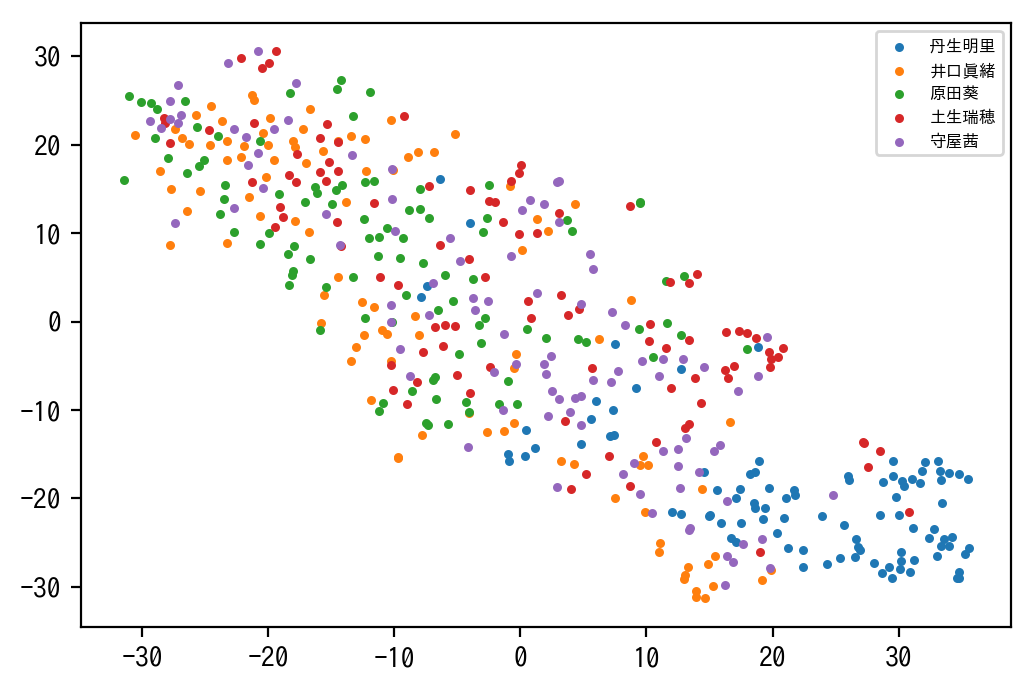

In [127]:
def get_groups( t_cluster ):
    groups_tmp = {}
    for i, l in enumerate( t_cluster ):
        if not l in groups_tmp: groups_tmp[l] = []
        groups_tmp[l].append( i )
    return groups_tmp

def plot( X_tmp, y_tmp, d1, d2 ):
    fig = plt.figure(figsize=(6,4),dpi=200)    

    groups = get_groups( y_tmp )
    for k, nodes in sorted( groups.items() ):
        plt.scatter(X_tmp[nodes, d1], X_tmp[nodes, d2], s=5, label=k) 

    plt.legend(prop={'size': 6})
    plt.show()

plot( X_r, y_moriya, 0, 1 )